# 1. Import all the necessary libraries and packages

---

In [ ]:
!pip install pydub
!pip install resampy
!pip install audiomentations

In [2]:
import math
import json
import os
import numpy as np
import soundfile as sf
import tensorflow as tf
import math

import librosa
import cv2
import shutil
import random
import resampy
import librosa.display

import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import scipy

import pydot

from sklearn.metrics import precision_score, recall_score, f1_score
from scipy import misc
from audiomentations import Compose, TimeStretch, PitchShift
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from PIL import Image
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import np_utils
from tensorflow import keras  


In [3]:
# Set the number of clusters for k-means clustering

originl_audio_path = '/content/drive/MyDrive/Colab Notebooks/DLProject_GTZAN Dataset/Data/genres_original'
processed_audio_path = '/content/drive/MyDrive/Colab Notebooks/DLProject_GTZAN Dataset/Data_Processed'
rawjson_path = '/content/drive/MyDrive/Colab Notebooks/DLProject_GTZAN Dataset/rawdata.json'
preprocessjson_path = '/content/drive/MyDrive/Colab Notebooks/DLProject_GTZAN Dataset/preprocesseddata.json'

In [4]:
# Defined the genres

genres = ['blues',
          'classical',
          'country',
          'disco',
          'hiphop',
          'jazz',
          'metal',
          'pop',
          'reggae',
          'rock']

# Change format of jazz audio clip due to errors 
Note: additional formatting has been applied to the audio clip jazz.00054. Using an online converter this track was formatted to a .wav format. 

---

In [5]:
# Setting variables /parameters
audio_sample_rate = 22050
audio_duration = 30
num_samples = audio_sample_rate * audio_duration

# set the input shape
# input_shape = (130, 13) # X_train.shape[1], X_train.shape[2],
EPOCHS = 10
BATCH_SIZE = 8
num_labels = 10

Blues:
  - Average duration: 30.01 seconds
  - Average number of channels: 661794.00

Classical:
  - Average duration: 30.03 seconds
  - Average number of channels: 662116.10

Country:
  - Average duration: 30.02 seconds
  - Average number of channels: 662027.76

Disco:
  - Average duration: 30.02 seconds
  - Average number of channels: 661934.80

Hiphop:
  - Average duration: 30.09 seconds
  - Average number of channels: 663468.24

Jazz:
  - Average duration: 30.03 seconds
  - Average number of channels: 662227.20

Metal:
  - Average duration: 30.00 seconds
  - Average number of channels: 661596.80

Pop:
  - Average duration: 30.00 seconds
  - Average number of channels: 661504.00

Reggae:
  - Average duration: 30.01 seconds
  - Average number of channels: 661622.90

Rock:
  - Average duration: 30.02 seconds
  - Average number of channels: 662010.58



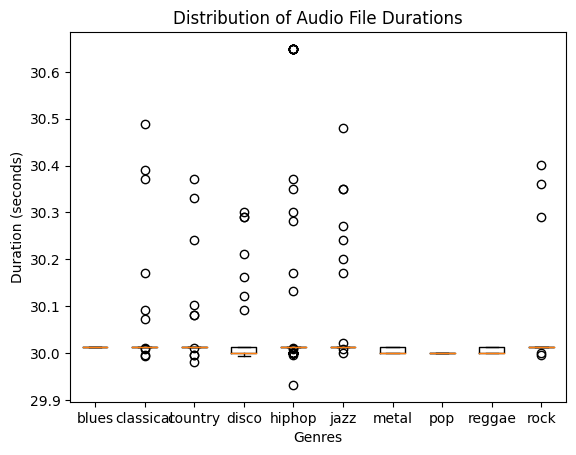

In [6]:
# Define a dictionary to store the properties of each genre
genres = {
    'blues': {'duration': [], 'sr': [], 'channels': []},
    'classical': {'duration': [], 'sr': [], 'channels': []},
    'country': {'duration': [], 'sr': [], 'channels': []},
    'disco': {'duration': [], 'sr': [], 'channels': []},
    'hiphop': {'duration': [], 'sr': [], 'channels': []},
    'jazz': {'duration': [], 'sr': [], 'channels': []},
    'metal': {'duration': [], 'sr': [], 'channels': []},
    'pop': {'duration': [], 'sr': [], 'channels': []},
    'reggae': {'duration': [], 'sr': [], 'channels': []},
    'rock': {'duration': [], 'sr': [], 'channels': []}
}

# Iterate over the audio files and extract their properties
for genre in genres.keys():
    genre_path = os.path.join(originl_audio_path, 
                              genre)
    for filename in os.listdir(genre_path):
        filepath = os.path.join(genre_path, 
                                filename)
        audio, sr = librosa.load(filepath)
        duration = librosa.get_duration(y=audio, sr=sr)
        channels = audio.shape[0]
        genres[genre]['duration'].append(duration)
        genres[genre]['sr'].append(sr)
        genres[genre]['channels'].append(channels)

# Calculate the average properties for each genre
for genre, properties in genres.items():
    duration_mean = np.mean(properties['duration'])
    sr_mean = np.mean(properties['sr'])
    channels_mean = np.mean(properties['channels'])
    print(f"{genre.capitalize()}:")
    print(f"  - Average duration: {duration_mean:.2f} seconds")
    print(f"  - Average number of channels: {channels_mean:.2f}")
    print()

# Plot the distribution of audio file durations across genres
durations = [properties['duration'] for properties in genres.values()]
plt.boxplot(durations)
plt.xticks(range(1, len(genres) + 1), 
           genres.keys())
plt.xlabel('Genres')
plt.ylabel('Duration (seconds)')
plt.title('Distribution of Audio File Durations')
plt.show()

The basic distribution shows the existence of outliers and this will have to be handled using some preprocessing approaches in the next stage:
we shall aim to unify the duration accross the dataset.

---

In [7]:
# Create empty lists to store the sample rates for each genre
sr_list = [[] for _ in range(len(genres))]

# Loop through the audio files and get the sample rate for each file
for i, genre in enumerate(genres):
    genre_path = os.path.join(originl_audio_path, 
                              genre)
    for filename in os.listdir(genre_path):
        file_path = os.path.join(genre_path, 
                                 filename)
        y, sr = librosa.load(file_path, 
                             sr=None)
        sr_list[i].append(sr)

# Calculate the statistics for each genre
stats = []
for i in range(len(genres)):
    sr_array = np.array(sr_list[i])
    stats.append((np.mean(sr_array), 
                  np.max(sr_array), 
                  np.min(sr_array)))
    
mean_sr = [np.mean(sr) for sr in sr_list]
max_sr = [np.max(sr) for sr in sr_list]
min_sr = [np.min(sr) for sr in sr_list]

# Print the statistics for each genre
for i, genre in enumerate(genres):
    print(f'{genre.capitalize()}:\n')
    print(f'Mean sample rate: {mean_sr[i]:.2f} Hz')
    print(f'Maximum sample rate: {max_sr[i]:.2f} Hz')
    print(f'Minimum sample rate: {min_sr[i]:.2f} Hz\n')

Blues:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Classical:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Country:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Disco:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Hiphop:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Jazz:

Mean sample rate: 22270.50 Hz
Maximum sample rate: 44100.00 Hz
Minimum sample rate: 22050.00 Hz

Metal:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Pop:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Reggae:

Mean sample rate: 22050.00 Hz
Maximum sample rate: 22050.00 Hz
Minimum sample rate: 22050.00 Hz

Rock:

Mean sample rate: 22050.00 Hz
Maximum sampl

# Variations in the sample rate 
Jazz:

Mean sample rate: 22270.50 Hz
Maximum sample rate: 44100.00 Hz
Minimum sample rate: 22050.00 Hz

In the Jazz genre we can see that there is some variation in the sample rate; with some audio tracks at 44100Hz. This will also be worked on.

---

In [8]:
# Create a list of all subdirectories (i.e., genres)
genres = sorted([d for d in os.listdir(originl_audio_path) if os.path.isdir(os.path.join(originl_audio_path, d))])

# Create an empty dictionary to store the properties for each genre
genre_properties = {}

# Loop over each genre
for genre in genres:
  
    # Create lists to store the properties for each audio clip in this genre
    durations = []
    sample_rates = []
    n_channels_list = []
    specs = []
    
    # Loop over each audio clip in this genre
    for filename in os.listdir(os.path.join(originl_audio_path, 
                                            genre)):
        # Load the audio clip and extract its properties
        filepath = os.path.join(originl_audio_path, 
                                genre, 
                                filename)
        audio, sr = librosa.load(filepath, 
                                 sr=None)
        duration = librosa.get_duration(y=audio, 
                                        sr=sr)
        n_channels = audio.shape[0]
        spec = librosa.stft(y=audio, 
                            hop_length=256, 
                            n_fft=512, 
                            center=True)
        mag_spec = np.abs(spec)
        log_mag_spec = librosa.amplitude_to_db(mag_spec)
        
        # Add the properties to the lists
        durations.append(duration)
        sample_rates.append(sr)
        n_channels_list.append(n_channels)
        specs.append(log_mag_spec)
    
    # Compute the average properties for this genre
    avg_duration = np.mean(durations)
    avg_sr = np.mean(sample_rates)
    avg_n_channels = np.mean(n_channels_list)
    
    # Add the properties to the dictionary
    genre_properties[genre] = {'duration': avg_duration,
                               'sample_rate': avg_sr,
                               'n_channels': avg_n_channels,
                               'specs': specs}

    # Plot the spectrogram for a random audio clip in this genre
    plt.figure()
    plt.title(f'{genre} spectrogram')
    plt.imshow(specs[np.random.randint(len(specs))],
               aspect='auto',
               origin='lower',
               extent=[0,
                       duration,
                       0,
                       sr/2])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.show()

# Print the properties for each genre
for genre, properties in genre_properties.items():
    print(f'{genre}:')
    print(f'  Duration: {properties["duration"]:.2f} s')
    print(f'  Sample rate: {properties["sample_rate"]:.2f} Hz')
    print(f'  Number of channels: {properties["n_channels"]:.0f}')

Output hidden; open in https://colab.research.google.com to view.

In [9]:
genre_dirs = os.listdir(originl_audio_path)
genre_counts = {}
# Check if the data is sequential
is_sequential = True
is_balanced = True
min_count = float('inf')
max_count = 0

for genre_dir in genre_dirs:
    genre_path = os.path.join(originl_audio_path, 
                              genre_dir)
    num_samples = len(os.listdir(genre_path))
    genre_counts[genre_dir] = num_samples
    if num_samples < min_count:
        min_count = num_samples
    if num_samples > max_count:
        max_count = num_samples
    filenames = os.listdir(genre_path)
    for i in range(len(filenames)-1):
        curr_filename = filenames[i]
        next_filename = filenames[i+1]
        try: # Adding a try-except block to skip filenames that cannot be converted to integers in the check for sequentiality.
            curr_index = int(curr_filename.split(".")[0])
            next_index = int(next_filename.split(".")[0])
            if curr_index + 1 != next_index:
                is_sequential = False
                break
        except ValueError:
            # Skip filenames that cannot be converted to integers
            continue
    if not is_sequential:
        break

balance_tolerance = 1
if max_count - min_count > balance_tolerance:
    is_balanced = False

df_counts = pd.DataFrame.from_dict(genre_counts,
                                   orient='index',
                                   columns=['Count'])
print("Genre sample counts:")
print(df_counts)

if is_sequential:
    print("The data is sequential")
else:
    print("The data is not sequential")

if is_balanced:
    print("The data is balanced")
else:
    print("The data is not balanced")

Genre sample counts:
           Count
disco        100
reggae       100
blues        100
metal        100
pop          100
hiphop       100
rock         100
country      100
jazz         100
classical    100
The data is sequential
The data is balanced


In [10]:
durations = []
for genre in os.listdir(originl_audio_path):
    genre_path = os.path.join(originl_audio_path, 
                              genre)
    for file_name in os.listdir(genre_path):
        song_path = os.path.join(genre_path, 
                                 file_name)
        y, sr = librosa.load(song_path, mono=True)
        duration = librosa.get_duration(y=y, 
                                        sr=sr)
        durations.append(duration)

durations = np.array(durations)
print("Audio duration statistics:")
print(f"Mean duration: {np.mean(durations):.2f} seconds")
print(f"Standard deviation: {np.std(durations):.2f} seconds")
print(f"Minimum duration: {np.min(durations):.2f} seconds")
print(f"Maximum duration: {np.max(durations):.2f} seconds")

Audio duration statistics:
Mean duration: 30.02 seconds
Standard deviation: 0.08 seconds
Minimum duration: 29.93 seconds
Maximum duration: 30.65 seconds


In [11]:
# Check variations in Frame sizes by genre:

def calculate_frame_size(audio_path):
    y, sr = librosa.load(audio_path, 
                         sr=None)
    return y.shape[0]

def calculate_average_frame_size(audio_folder_path):
    frame_sizes = []
    for file_name in os.listdir(audio_folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(audio_folder_path, 
                                     file_name)
            frame_size = calculate_frame_size(file_path)
            frame_sizes.append(frame_size)
    return sum(frame_sizes) / len(frame_sizes)

for genre_folder_name in os.listdir(originl_audio_path):
    originl_audio_path_full = os.path.join(originl_audio_path,
                                          genre_folder_name)
    if os.path.isdir(originl_audio_path_full):
        average_frame_size = calculate_average_frame_size(originl_audio_path_full)
        print(f'Genre {genre_folder_name}: {average_frame_size} frames')

Genre disco: 661934.8 frames
Genre reggae: 661622.9 frames
Genre blues: 661794.0 frames
Genre metal: 661596.8 frames
Genre pop: 661504.0 frames
Genre hiphop: 663468.24 frames
Genre rock: 662010.58 frames
Genre country: 662027.76 frames
Genre jazz: 668842.24 frames
Genre classical: 662116.1 frames


The Audio files are at first glance balanced with each of the  ten genre containing one hundred audio clips each with each audio clip named in a sequential manner within each folder. But closer inspection highlights that for each genre there is a significant variation in duration length of each audio file with arange of 29.93 seconds to 30.65 seconds so there is an inbalance and this results in the mismatch of shapes when computing the mean of the audio data. Different sample rates could  also affect the accuracy of the model. This is because models typically require that all input data have the same shape and size. 

If audio clips have different sample rates, they will have different lengths and different numbers of samples, which could lead to inconsistencies in the training and evaluation of the model.

To avoid this issue, it is important to resample all audio clips to a common sample rate before feeding them into a classification model. 

---



# Data Preprocessing: Audio data needs to be preprocessed before it can be fed into a deep learning model. Here are some common preprocessing steps:

*   Convert audio files into a fixed-length format, such as a fixed duration or a fixed number of samples.

*   Apply normalization techniques such as mean-variance normalization or min-max scaling.

*   Extract audio features such as Mel-frequency cepstral coefficients (MFCCs), spectrograms, or chroma features.


---



In [12]:
# # Set input and output directories
input_dir = originl_audio_path
output_dir = processed_audio_path

# Set audio parameters
target_sr = 22050
target_dur = 30  # in seconds

# Loop through genre folders
for genre_folder in os.listdir(input_dir):
    genre_folder_path = os.path.join(input_dir, 
                                     genre_folder)
    if os.path.isdir(genre_folder_path):
        output_genre_folder_path = os.path.join(output_dir, 
                                                genre_folder)
        if not os.path.exists(output_genre_folder_path):
            os.makedirs(output_genre_folder_path)
        # Loop through audio files in genre folder
        for filename in tqdm(os.listdir(genre_folder_path)):
            if filename.endswith('.wav'):
                filepath = os.path.join(genre_folder_path, 
                                        filename)
                # Read audio file
                audio, sr = sf.read(filepath)
                # Truncate or pad audio to target duration
                target_length = target_dur * target_sr
                if len(audio) < target_length:
                    # Pad with zeros
                    audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
                else:
                    # Truncate
                    audio = audio[:target_length]
                # Resample audio to target sampling rate
                if sr != target_sr:
                    audio = resampy.resample(audio, 
                                             sr, 
                                             target_sr)
                # Save preprocessed audio to output directory
                output_filepath = os.path.join(output_genre_folder_path, 
                                               filename)
                sf.write(output_filepath, 
                         audio, 
                         target_sr)

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


In [13]:
durations = []
for genre in os.listdir(processed_audio_path):
    genre_path = os.path.join(processed_audio_path, 
                              genre)
    for file_name in os.listdir(genre_path):
        song_path = os.path.join(genre_path, 
                                 file_name)
        y, sr = librosa.load(song_path, 
                             mono=True)
        duration = librosa.get_duration(y=y, 
                                        sr=sr)
        durations.append(duration)

durations = np.array(durations)
print("Audio duration statistics:")
print(f"Mean duration: {np.mean(durations):.2f} seconds")
print(f"Standard deviation: {np.std(durations):.2f} seconds")
print(f"Minimum duration: {np.min(durations):.2f} seconds")
print(f"Maximum duration: {np.max(durations):.2f} seconds")

Audio duration statistics:
Mean duration: 30.00 seconds
Standard deviation: 0.00 seconds
Minimum duration: 30.00 seconds
Maximum duration: 30.00 seconds


In [14]:
input_dir = processed_audio_path

total_duration = 0
min_duration = float('inf')
max_duration = float('-inf')
count = 0

# Loop through genre folders
for genre_folder in os.listdir(input_dir):
    genre_folder_path = os.path.join(input_dir, 
                                     genre_folder)
    if os.path.isdir(genre_folder_path):
        # Loop through audio files in genre folder
        for filename in os.listdir(genre_folder_path):
            if filename.endswith('.wav'):
                filepath = os.path.join(genre_folder_path, 
                                        filename)
                # Read audio file
                audio, sr = sf.read(filepath)
                duration = len(audio) / sr  # calculate duration in seconds
                total_duration += duration
                count += 1
                if duration < min_duration:
                    min_duration = duration
                if duration > max_duration:
                    max_duration = duration

# Calculate average duration
if count > 0:
    avg_duration = total_duration / count
else:
    avg_duration = 0

# Print statistics
print("Audio duration statistics:")
print("Mean duration: {:.2f} seconds".format(avg_duration))
print("Minimum duration: {:.2f} seconds".format(min_duration))
print("Maximum duration: {:.2f} seconds".format(max_duration))

Audio duration statistics:
Mean duration: 30.00 seconds
Minimum duration: 30.00 seconds
Maximum duration: 30.00 seconds


In [15]:
genre_folder_path = processed_audio_path
for genre_folder_name in os.listdir(genre_folder_path):
    genre_folder_path_full = os.path.join(genre_folder_path, 
                                          genre_folder_name)
    if os.path.isdir(genre_folder_path_full):
        average_frame_size = calculate_average_frame_size(genre_folder_path_full)
        print(f'Genre {genre_folder_name}: {average_frame_size} frames')

Genre disco: 661500.0 frames
Genre reggae: 661500.0 frames
Genre blues: 661500.0 frames
Genre metal: 661500.0 frames
Genre pop: 661500.0 frames
Genre hiphop: 661500.0 frames
Genre rock: 661500.0 frames
Genre country: 661500.0 frames
Genre jazz: 661500.0 frames
Genre classical: 661500.0 frames


Blues:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Classical:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Country:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Disco:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Hiphop:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Jazz:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Metal:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Pop:
  - Average duration: 30.00 seconds
  - Average sample rate: 22050.00 Hz
  - Average number of channels: 661500.00

Reggae:
  - 

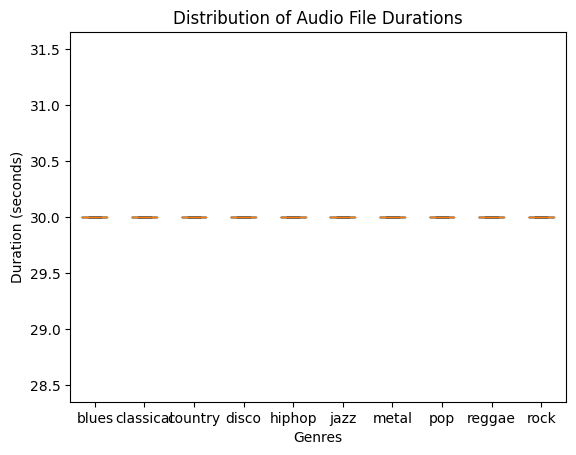

In [16]:
# Define a dictionary to store the properties of each genre
genres = {
    'blues': {'duration': [], 'sr': [], 'channels': []},
    'classical': {'duration': [], 'sr': [], 'channels': []},
    'country': {'duration': [], 'sr': [], 'channels': []},
    'disco': {'duration': [], 'sr': [], 'channels': []},
    'hiphop': {'duration': [], 'sr': [], 'channels': []},
    'jazz': {'duration': [], 'sr': [], 'channels': []},
    'metal': {'duration': [], 'sr': [], 'channels': []},
    'pop': {'duration': [], 'sr': [], 'channels': []},
    'reggae': {'duration': [], 'sr': [], 'channels': []},
    'rock': {'duration': [], 'sr': [], 'channels': []}
}

# Iterate over the audio files and extract their properties
for genre in genres.keys():
    genre_path = os.path.join(processed_audio_path, 
                              genre)
    for filename in os.listdir(genre_path):
        filepath = os.path.join(genre_path, 
                                filename)
        audio, sr = librosa.load(filepath)
        duration = librosa.get_duration(y=audio, 
                                        sr=sr)
        channels = audio.shape[0]
        genres[genre]['duration'].append(duration)
        genres[genre]['sr'].append(sr)
        genres[genre]['channels'].append(channels)

# Calculate the average properties for each genre
for genre, properties in genres.items():
    duration_mean = np.mean(properties['duration'])
    sr_mean = np.mean(properties['sr'])
    channels_mean = np.mean(properties['channels'])
    print(f"{genre.capitalize()}:")
    print(f"  - Average duration: {duration_mean:.2f} seconds")
    print(f"  - Average sample rate: {sr_mean:.2f} Hz")
    print(f"  - Average number of channels: {channels_mean:.2f}")
    print()

# Plot the distribution of audio file durations across genres
durations = [properties['duration'] for properties in genres.values()]
plt.boxplot(durations)
plt.xticks(range(1, len(genres) + 1), genres.keys())
plt.xlabel('Genres')
plt.ylabel('Duration (seconds)')
plt.title('Distribution of Audio File Durations')
plt.show()

In [17]:
# Create a list of all subdirectories (i.e., genres)
genres = sorted([d for d in os.listdir(processed_audio_path) if os.path.isdir(os.path.join(processed_audio_path, 
                                                                                           d))])

# Create an empty dictionary to store the properties for each genre
genre_properties = {}

# Loop over each genre
for genre in genres:
    # Create lists to store the properties for each audio clip in this genre
    durations = []
    sample_rates = []
    n_channels_list = []
    specs = []
    
    # Loop over each audio clip in this genre
    for filename in os.listdir(os.path.join(processed_audio_path, 
                                            genre)):
        # Load the audio clip and extract its properties
        filepath = os.path.join(processed_audio_path, 
                                genre, 
                                filename)
        audio, sr = librosa.load(filepath, 
                                 sr=None)
        duration = librosa.get_duration(y=audio, 
                                        sr=sr)
        n_channels = audio.shape[0]
        spec = librosa.stft(y=audio, 
                            hop_length=512, 
                            n_fft=2048, 
                            center=True)
        mag_spec = np.abs(spec)
        log_mag_spec = librosa.amplitude_to_db(mag_spec)
        
        # Add the properties to the lists
        durations.append(duration)
        sample_rates.append(sr)
        n_channels_list.append(n_channels)
        specs.append(log_mag_spec)
    
    # Compute the average properties for this genre
    avg_duration = np.mean(durations)
    avg_sr = np.mean(sample_rates)
    avg_n_channels = np.mean(n_channels_list)
    
    # Add the properties to the dictionary
    genre_properties[genre] = {'duration': avg_duration,
                               'sample_rate': avg_sr,
                               'n_channels': avg_n_channels,
                               'specs': specs}

    # Plot the spectrogram for a random audio clip in this genre
    plt.figure()
    plt.title(f'{genre} spectrogram')
    plt.imshow(specs[np.random.randint(len(specs))], 
               aspect='auto', 
               origin='lower',
               extent=[0, 
                       duration, 
                       0, 
                       sr/2])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.show()

# Print the properties for each genre
for genre, properties in genre_properties.items():
    print(f'{genre}:')
    print(f'  Duration: {properties["duration"]:.2f} s')
    print(f'  Sample rate: {properties["sample_rate"]:.2f} Hz')
    print(f'  Number of channels: {properties["n_channels"]:.0f}')


Output hidden; open in https://colab.research.google.com to view.

# Feature extraction and Model training:

Features will be extracted for both the raw data and the preprocessed data.

---



In [7]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels."""

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(num_samples / num_segments) # data augmentation
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # get total number of files in dataset
    num_files = 0
    for _, _, files in os.walk(dataset_path):
        num_files += len(files)

    # loop through all genre sub-folder
    with tqdm(total=num_files, unit="file") as pbar:
        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
            # ensure we're processing a genre
            if dirpath is not dataset_path:

                # save genre label in the mapping
                semantic_label = dirpath.split("/")[-1]
                data["mapping"].append(semantic_label)

                # process all audio files in genre 
                for f in filenames:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=audio_sample_rate)

                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)

                    # update progress bar
                    pbar.update(1)

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [8]:
# Raw dataset will be segmented and features and labels saved to json file 

save_mfcc(originl_audio_path, rawjson_path, num_segments=10)

100%|██████████| 1000/1000 [03:45<00:00,  4.44file/s]


In [12]:
# Preprocessed dataset will be segmented and features and labels saved to a json file

save_mfcc(processed_audio_path, preprocessjson_path, num_segments=10)

100%|██████████| 1000/1000 [03:41<00:00,  4.52file/s]


In [7]:
def load_data(path):
    """
    Load MFCC data and labels from a JSON file.

    Parameters:
    path (str): Path to the JSON file containing the MFCC data and labels.

    Returns:
    tuple: A tuple containing the MFCC data and corresponding labels.
    """
    with open(path, "r") as f:
        data = json.load(f)
    
    # check that the expected keys are present in the JSON data
    if "mfcc" not in data or "labels" not in data:
        raise ValueError("JSON data is missing 'mfcc' or 'labels' key")
    
    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data successfully loaded!")
    return X, y

In [8]:
# Load raw Json file the json data into X, y array variables

try:
    X, y = load_data(rawjson_path)
except ValueError as e:
    print(f"Error loading data: {str(e)}")

Data successfully loaded!


In [9]:
print(X.shape)
y.shape

(9996, 130, 13)


(9996,)

In [10]:
# Load processed data Json file the json data into X, y array variables

try:
    Xp, yp = load_data(preprocessjson_path)
except ValueError as e:
    print(f"Error loading data: {str(e)}")

Data successfully loaded!


In [11]:
print(Xp.shape)
yp.shape

(10000, 130, 13)


(10000,)

In [12]:
# Split the data into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

print(X_train.shape, X_test.shape, X_val.shape)

(5997, 130, 13) (2499, 130, 13) (1500, 130, 13)


In [13]:
# Split the data into train, test and validation sets
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size = 0.25, random_state=42)
Xp_train, Xp_val, yp_train, yp_val = train_test_split(Xp_train, yp_train, test_size = 0.2, random_state=42)

print(Xp_train.shape, Xp_test.shape, Xp_val.shape)

(6000, 130, 13) (2500, 130, 13) (1500, 130, 13)


In [62]:
# create the model
model = Sequential()

# add layers with regularized layers

# input layer
model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

# 1st dense layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# 2nd dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# 3rd dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(10, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64)

# evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/100
94/94 [==============================] - 3s 15ms/step - loss: 12.0038 - accuracy: 0.1429 - val_loss: 2.1336 - val_accuracy: 0.2313
Epoch 2/100
94/94 [==============================] - 1s 13ms/step - loss: 2.3291 - accuracy: 0.1457 - val_loss: 2.1922 - val_accuracy: 0.1753
Epoch 3/100
94/94 [==============================] - 1s 13ms/step - loss: 2.2465 - accuracy: 0.1469 - val_loss: 2.1972 - val_accuracy: 0.1673
Epoch 4/100
94/94 [==============================] - 1s 13ms/step - loss: 2.2372 - accuracy: 0.1652 - val_loss: 2.1016 - val_accuracy: 0.2280
Epoch 5/100
94/94 [==============================] - 2s 19ms/step - loss: 2.1773 - accuracy: 0.1876 - val_loss: 2.0759 - val_accuracy: 0.2327
Epoch 6/100
94/94 [==============================] - 3s 34ms/step - loss: 2.1274 - accuracy: 0.1973 - val_loss: 2.1023 - val_accuracy: 0.2060
Epoch 7/100
94/94 [==============================] - 1s 14ms/step - loss: 2.1288 - accuracy: 0.1931 - val_loss: 2.0847 - val_accuracy: 0.2113
Epoch

In [63]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 1690)              0         
                                                                 
 dense_38 (Dense)            (None, 256)               432896    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)              

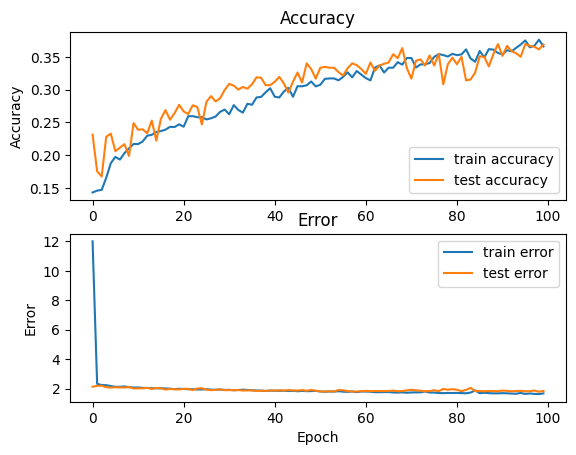

In [64]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error")    
    plt.show()

plot_history(history)

In [65]:
# create the model
modelp = Sequential()

# add layers
modelp.add(Flatten(input_shape=(Xp_train.shape[1], Xp_train.shape[2])))
modelp.add(Dense(256, activation='relu'))
modelp.add(Dropout(0.3))
modelp.add(Dense(128, activation='relu'))
modelp.add(Dropout(0.3))
modelp.add(Dense(64, activation='relu'))
modelp.add(Dropout(0.3))
modelp.add(Dense(10, activation='softmax'))

# compile the model
modelp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model
historyp = modelp.fit(Xp_train, yp_train, validation_data=(Xp_val, yp_val), epochs=100, batch_size=64)

# evaluate the model
testp_loss, testp_acc = modelp.evaluate(Xp_test, yp_test, verbose=2)
print('Test accuracy:', testp_acc)

Epoch 1/100
94/94 [==============================] - 3s 16ms/step - loss: 14.4279 - accuracy: 0.1440 - val_loss: 2.2035 - val_accuracy: 0.1780
Epoch 2/100
94/94 [==============================] - 2s 19ms/step - loss: 2.2941 - accuracy: 0.1703 - val_loss: 2.1421 - val_accuracy: 0.2180
Epoch 3/100
94/94 [==============================] - 2s 20ms/step - loss: 2.2202 - accuracy: 0.1727 - val_loss: 2.1263 - val_accuracy: 0.1927
Epoch 4/100
94/94 [==============================] - 2s 18ms/step - loss: 2.2339 - accuracy: 0.1833 - val_loss: 2.0856 - val_accuracy: 0.2173
Epoch 5/100
94/94 [==============================] - 1s 13ms/step - loss: 2.1704 - accuracy: 0.1898 - val_loss: 2.1214 - val_accuracy: 0.1853
Epoch 6/100
94/94 [==============================] - 1s 13ms/step - loss: 2.1729 - accuracy: 0.1832 - val_loss: 2.1709 - val_accuracy: 0.1633
Epoch 7/100
94/94 [==============================] - 1s 13ms/step - loss: 2.1541 - accuracy: 0.1923 - val_loss: 2.1310 - val_accuracy: 0.1733
Epoch

In [66]:
modelp.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 1690)              0         
                                                                 
 dense_42 (Dense)            (None, 256)               432896    
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dropout_30 (Dropout)        (None, 64)              

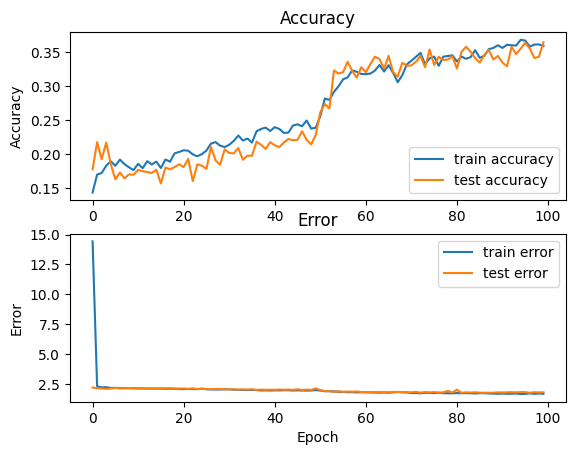

In [67]:
plot_history(historyp)

In [68]:
# Define model architecture

modelCNN = tf.keras.Sequential([
    
    # input layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),

    # Conv layer 
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Flatten output and feed to dense layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # output layer
    layers.Dense(num_labels, activation='softmax')
])

# Compile model
modelCNN.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Train model
historyCNN = modelCNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100,
    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    verbose=2)

# evaluate the model
test_loss, test_acc = modelCNN.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/100
94/94 - 46s - loss: 4.0598 - accuracy: 0.1632 - val_loss: 2.0008 - val_accuracy: 0.2593 - 46s/epoch - 492ms/step
Epoch 2/100
94/94 - 41s - loss: 2.0167 - accuracy: 0.2541 - val_loss: 1.7340 - val_accuracy: 0.3987 - 41s/epoch - 432ms/step
Epoch 3/100
94/94 - 41s - loss: 1.8276 - accuracy: 0.3240 - val_loss: 1.5425 - val_accuracy: 0.4407 - 41s/epoch - 432ms/step
Epoch 4/100
94/94 - 38s - loss: 1.6937 - accuracy: 0.3730 - val_loss: 1.4667 - val_accuracy: 0.4727 - 38s/epoch - 403ms/step
Epoch 5/100
94/94 - 40s - loss: 1.6014 - accuracy: 0.4125 - val_loss: 1.3930 - val_accuracy: 0.5073 - 40s/epoch - 426ms/step
Epoch 6/100
94/94 - 38s - loss: 1.5106 - accuracy: 0.4439 - val_loss: 1.3544 - val_accuracy: 0.5313 - 38s/epoch - 402ms/step
Epoch 7/100
94/94 - 40s - loss: 1.4294 - accuracy: 0.4706 - val_loss: 1.3677 - val_accuracy: 0.5233 - 40s/epoch - 420ms/step
Epoch 8/100
94/94 - 41s - loss: 1.3629 - accuracy: 0.4904 - val_loss: 1.2749 - val_accuracy: 0.5473 - 41s/epoch - 440ms/step


In [69]:
modelCNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 9, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_31 (Dropout)        (None, 63, 4, 64)         0         
                                                                 
 flatten_12 (Flatten)        (None, 16128)             0         
                                                                 
 dense_46 (Dense)            (None, 128)               2064512   
                                                     

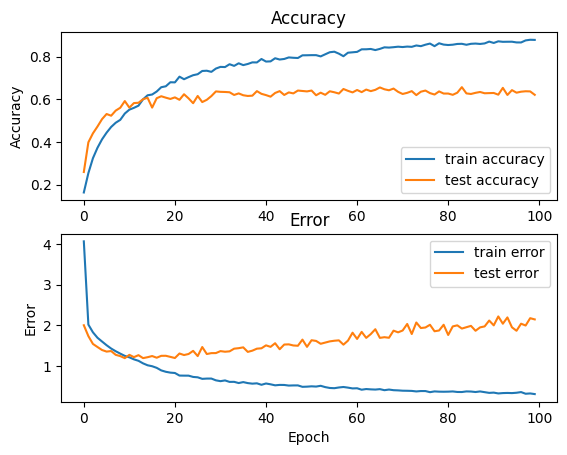

In [70]:
plot_history(historyCNN)

In [14]:
# Define model architecture

modelCNNp = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(Xp_train.shape[1], Xp_train.shape[2], 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

# Compile model
modelCNNp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Train model
historyCNNp = modelCNNp.fit(
    Xp_train, yp_train,
    validation_data=(Xp_val, yp_val),
    batch_size=64,
    epochs=100,
    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    verbose=2)

# evaluate the model
testp_loss, testp_acc = modelCNNp.evaluate(Xp_test, yp_test, verbose=2)
print('Test accuracy:', testp_acc)

Epoch 1/100
94/94 - 13s - loss: 3.6557 - accuracy: 0.2717 - val_loss: 1.6311 - val_accuracy: 0.4187 - 13s/epoch - 139ms/step
Epoch 2/100
94/94 - 1s - loss: 1.6087 - accuracy: 0.4300 - val_loss: 1.5024 - val_accuracy: 0.4680 - 727ms/epoch - 8ms/step
Epoch 3/100
94/94 - 1s - loss: 1.3836 - accuracy: 0.5017 - val_loss: 1.3409 - val_accuracy: 0.5207 - 732ms/epoch - 8ms/step
Epoch 4/100
94/94 - 1s - loss: 1.2064 - accuracy: 0.5700 - val_loss: 1.2733 - val_accuracy: 0.5433 - 808ms/epoch - 9ms/step
Epoch 5/100
94/94 - 1s - loss: 1.0583 - accuracy: 0.6202 - val_loss: 1.1903 - val_accuracy: 0.5800 - 727ms/epoch - 8ms/step
Epoch 6/100
94/94 - 1s - loss: 0.9221 - accuracy: 0.6687 - val_loss: 1.1623 - val_accuracy: 0.5793 - 845ms/epoch - 9ms/step
Epoch 7/100
94/94 - 1s - loss: 0.8026 - accuracy: 0.7177 - val_loss: 1.2111 - val_accuracy: 0.5867 - 804ms/epoch - 9ms/step
Epoch 8/100
94/94 - 1s - loss: 0.7067 - accuracy: 0.7470 - val_loss: 1.1726 - val_accuracy: 0.5993 - 868ms/epoch - 9ms/step
Epoch 9

In [15]:
modelCNNp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 9, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 4, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 4, 64)         0         
                                                                 
 flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense (Dense)               (None, 128)               2064512   
                                                        

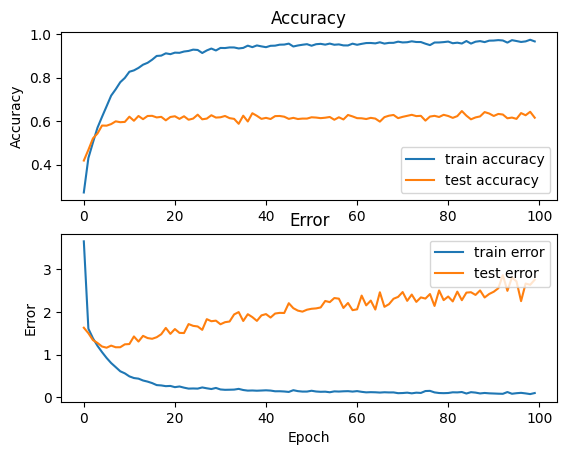

In [17]:
plot_history(historyCNNp)

In [18]:
# Define model architecture
modelLSTM = tf.keras.Sequential([
    layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='softmax')
])

# Compile the model
modelLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
historyLSTM = modelLSTM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64)

# Evaluate the model
test_loss, test_acc = modelLSTM.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/100
94/94 [==============================] - 6s 20ms/step - loss: 2.2943 - accuracy: 0.1439 - val_loss: 2.2599 - val_accuracy: 0.1567
Epoch 2/100
94/94 [==============================] - 1s 11ms/step - loss: 2.1992 - accuracy: 0.1773 - val_loss: 2.1806 - val_accuracy: 0.1800
Epoch 3/100
94/94 [==============================] - 1s 11ms/step - loss: 2.1264 - accuracy: 0.2196 - val_loss: 2.1172 - val_accuracy: 0.2293
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 2.0669 - accuracy: 0.2531 - val_loss: 2.0654 - val_accuracy: 0.2547
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 2.0167 - accuracy: 0.2820 - val_loss: 2.0236 - val_accuracy: 0.2773
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 1.9704 - accuracy: 0.3108 - val_loss: 1.9812 - val_accuracy: 0.3053
Epoch 7/100
94/94 [==============================] - 1s 8ms/step - loss: 1.9270 - accuracy: 0.3350 - val_loss: 1.9424 - val_accuracy: 0.3220
Epoch 8/10

In [19]:
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19968     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 22,378
Trainable params: 22,378
Non-trainable params: 0
_________________________________________________________________


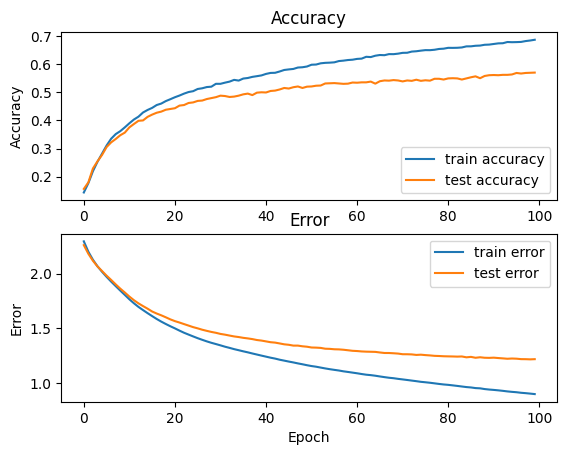

In [20]:
plot_history(historyLSTM)

In [21]:
# Define model architecture
modelLSTMp = tf.keras.Sequential([
    layers.LSTM(64, input_shape=(Xp_train.shape[1], Xp_train.shape[2])),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='softmax')
])

# Compile the model
modelLSTMp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
historyLSTMp = modelLSTMp.fit(Xp_train, yp_train, validation_data=(Xp_val, yp_val), epochs=100, batch_size=64)

# Evaluate the model
testp_loss, testp_acc = modelLSTMp.evaluate(Xp_test, yp_test, verbose=2)
print('Test accuracy:', testp_acc)

Epoch 1/100
94/94 [==============================] - 4s 16ms/step - loss: 2.3634 - accuracy: 0.0675 - val_loss: 2.3221 - val_accuracy: 0.0873
Epoch 2/100
94/94 [==============================] - 1s 12ms/step - loss: 2.2851 - accuracy: 0.1183 - val_loss: 2.2674 - val_accuracy: 0.1453
Epoch 3/100
94/94 [==============================] - 1s 11ms/step - loss: 2.2255 - accuracy: 0.1910 - val_loss: 2.2139 - val_accuracy: 0.2093
Epoch 4/100
94/94 [==============================] - 1s 11ms/step - loss: 2.1674 - accuracy: 0.2475 - val_loss: 2.1606 - val_accuracy: 0.2473
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 2.1046 - accuracy: 0.2822 - val_loss: 2.1015 - val_accuracy: 0.2853
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 2.0353 - accuracy: 0.3042 - val_loss: 2.0334 - val_accuracy: 0.3053
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 1.9644 - accuracy: 0.3257 - val_loss: 1.9693 - val_accuracy: 0.3100
Epoch 8/1

In [22]:
modelLSTMp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                19968     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 22,378
Trainable params: 22,378
Non-trainable params: 0
_________________________________________________________________


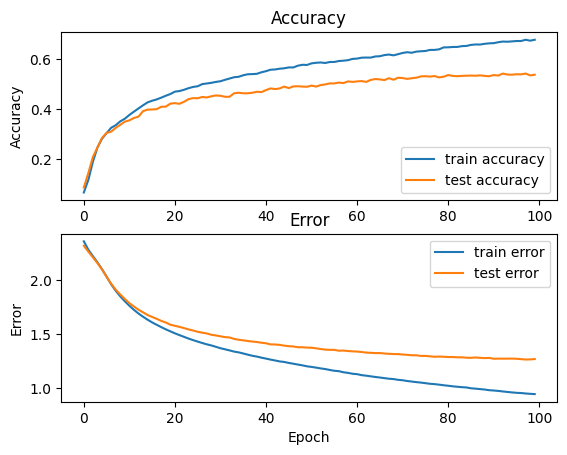

In [23]:
plot_history(historyLSTMp)

This first training of the model shows that the model has performed poorly with only aboyt 9% of the audio samples in the training set were correctly classified by the model.

The validation accuracy is also low which means the model would performm poorly on unseen data. This could also suggest that the model is likely overfitting on the training data, memorising the training samples instead of learning the underlying patterns that can be generalised to new samples.

The loss values also indicates that the model is experiencing numerical overflow or underflow (in this case it is overflow) which may occur when weights or activations become too large or too small respectively. Hence unstable / unpredictable behavior of the model. 

In [26]:
for n in range(10):
  i = random.randint(0, len(Xp_test))
  X_to_predict = Xp_test[i] 
  y_to_predict = yp_test[i] 

  print("\nReal genre:", genres[y_to_predict])

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = modelCNNp.predict(X_to_predict)

  predicted_index = np.argmax(prediction, axis=1)

  print("predicted Genre:", genres[int(predicted_index)])




Real genre: reggae
1/1 [==============================] - 0s 26ms/step
predicted Genre: reggae

Real genre: hiphop
1/1 [==============================] - 0s 25ms/step
predicted Genre: blues

Real genre: metal
1/1 [==============================] - 0s 27ms/step
predicted Genre: metal

Real genre: classical
1/1 [==============================] - 0s 29ms/step
predicted Genre: jazz

Real genre: metal
1/1 [==============================] - 0s 26ms/step
predicted Genre: metal

Real genre: rock
1/1 [==============================] - 0s 25ms/step
predicted Genre: rock

Real genre: jazz
1/1 [==============================] - 0s 28ms/step
predicted Genre: jazz

Real genre: metal
1/1 [==============================] - 0s 27ms/step
predicted Genre: country

Real genre: classical
1/1 [==============================] - 0s 25ms/step
predicted Genre: classical

Real genre: hiphop
1/1 [==============================] - 0s 25ms/step
predicted Genre: hiphop


In [ ]:
predictions = []
real_genres = []

for i, (X_to_predict, y_to_predict) in enumerate(zip(Xp_test, yp_test)):
    real_genre = genres[y_to_predict]
    real_genres.append(real_genre)

    X_to_predict = X_to_predict[np.newaxis, ...]
    prediction = modelCNNp.predict(X_to_predict)
    predicted_index = np.argmax(prediction, axis=1)
    predicted_genre = genres[int(predicted_index)]
    predictions.append(predicted_genre)

    print(f"\nSample {i+1}")
    print(f"Real genre: {real_genre}")
    print(f"Predicted genre: {predicted_genre}")

print("\nResults:")
for i, (real_genre, predicted_genre) in enumerate(zip(real_genres, predictions)):
    print(f"Sample {i+1}: Real genre: {real_genre}, Predicted genre: {predicted_genre}")
